In [7]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBoost
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
plt.style.use("seaborn");plt.style.use("classic")
from itertools import product
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (13, 8)
plt.rcParams["figure.dpi"] = 100

In [ ]:
cd data

In [13]:
#load data
with open("data_w", "rb") as f:
    data_w = pickle.load(f)
    
with open("data_2w", "rb") as f:
    data_2w = pickle.load(f)
    
with open("data_3w", "rb") as f:
    data_3w = pickle.load(f)
    
with open("data_m", "rb") as f:
    data_m = pickle.load(f)

for dat in [data_m, data_2w, data_3w, data_w]:
    for city in dat:
        del dat[city]["delete"]
        del dat[city]["recreate"]
        del dat[city]["activity"]
        
cities = list(data_m.keys())

In [14]:
def model_predictions(frequency, city, alpha=15, tolerance=0.2, max_depth=None):
    if frequency == "1w":
        data = data_w[city]
        test_size = 48
        max_lag = 3
    elif frequency == "2w":
        data = data_2w[city]
        test_size = 24
        max_lag = 2
    elif frequency == "3w":
        test_size = 16
        data = data_3w[city]
        max_lag = 2
    elif frequency == "4w":
        data = data_m[city]
        test_size = 12
        max_lag = 2
    
    cols = data.columns.to_list()
    #1 Obtain BL1 predictions and errors
    pred_BL1 = data[-test_size-1:].shift(1).dropna()
    
    
    pred_BL2 = data[-test_size-2:].shift(1).rolling(2).mean().dropna()
    
    
    #2 Fit the statistical models
    # create objective matrix
    df = data.copy()
    for col in cols:
        for l in range(1, max_lag+1):
            df[col+"(t-%s)" % l] = df[col].shift(l)
            
    df = df.dropna()
    df_rf = df.copy()
    #add additional temporal features for the RF
    df_rf["week"] = df_rf.index.week
    df_rf["month"] = df_rf.index.month
    X_rf = df_rf[df_rf.columns.difference(cols)].values
    X = df[df.columns.difference(cols)].values
    y = df[cols].values
    y_train, y_test = y[:-test_size], y[-test_size:]
    X_train, X_test = X[:-test_size], X[-test_size:]
    X_train_rf, X_test_rf = X_rf[:-test_size], X_rf[-test_size:]
    
    #Train VAR
    VAR = Lasso(alpha=alpha, tol=tolerance)
    VAR.fit(X_train, y_train)
    pred_VAR = VAR.predict(X_test)
    #Train RF
    RF = RandomForestRegressor(n_estimators=200,
                               max_depth = max_depth, n_jobs=-1)
    RF.fit(X_train_rf, y_train)
    pred_RF = RF.predict(X_test_rf)
    return {"True" : pd.DataFrame(y_test, columns=cols, index= df[-test_size:].index),
            "BL1" : pd.DataFrame(pred_BL1, columns=cols, index= df[-test_size:].index),
            "BL2" : pd.DataFrame(pred_BL2, columns=cols, index= df[-test_size:].index), 
            "VAR" : pd.DataFrame(pred_VAR, columns=cols, index= df[-test_size:].index), 
            "RF" : pd.DataFrame(pred_RF, columns=cols, index= df[-test_size:].index) }
            

def compare_predictions(variable, frequency, city):
    res = model_predictions(frequency, city)
    return pd.DataFrame({method : res[method][variable] for method in res}, index = res["True"].index)
    



Text(0.5, 1.0, 'One Step ahead prediction for variable <MODIFY>')

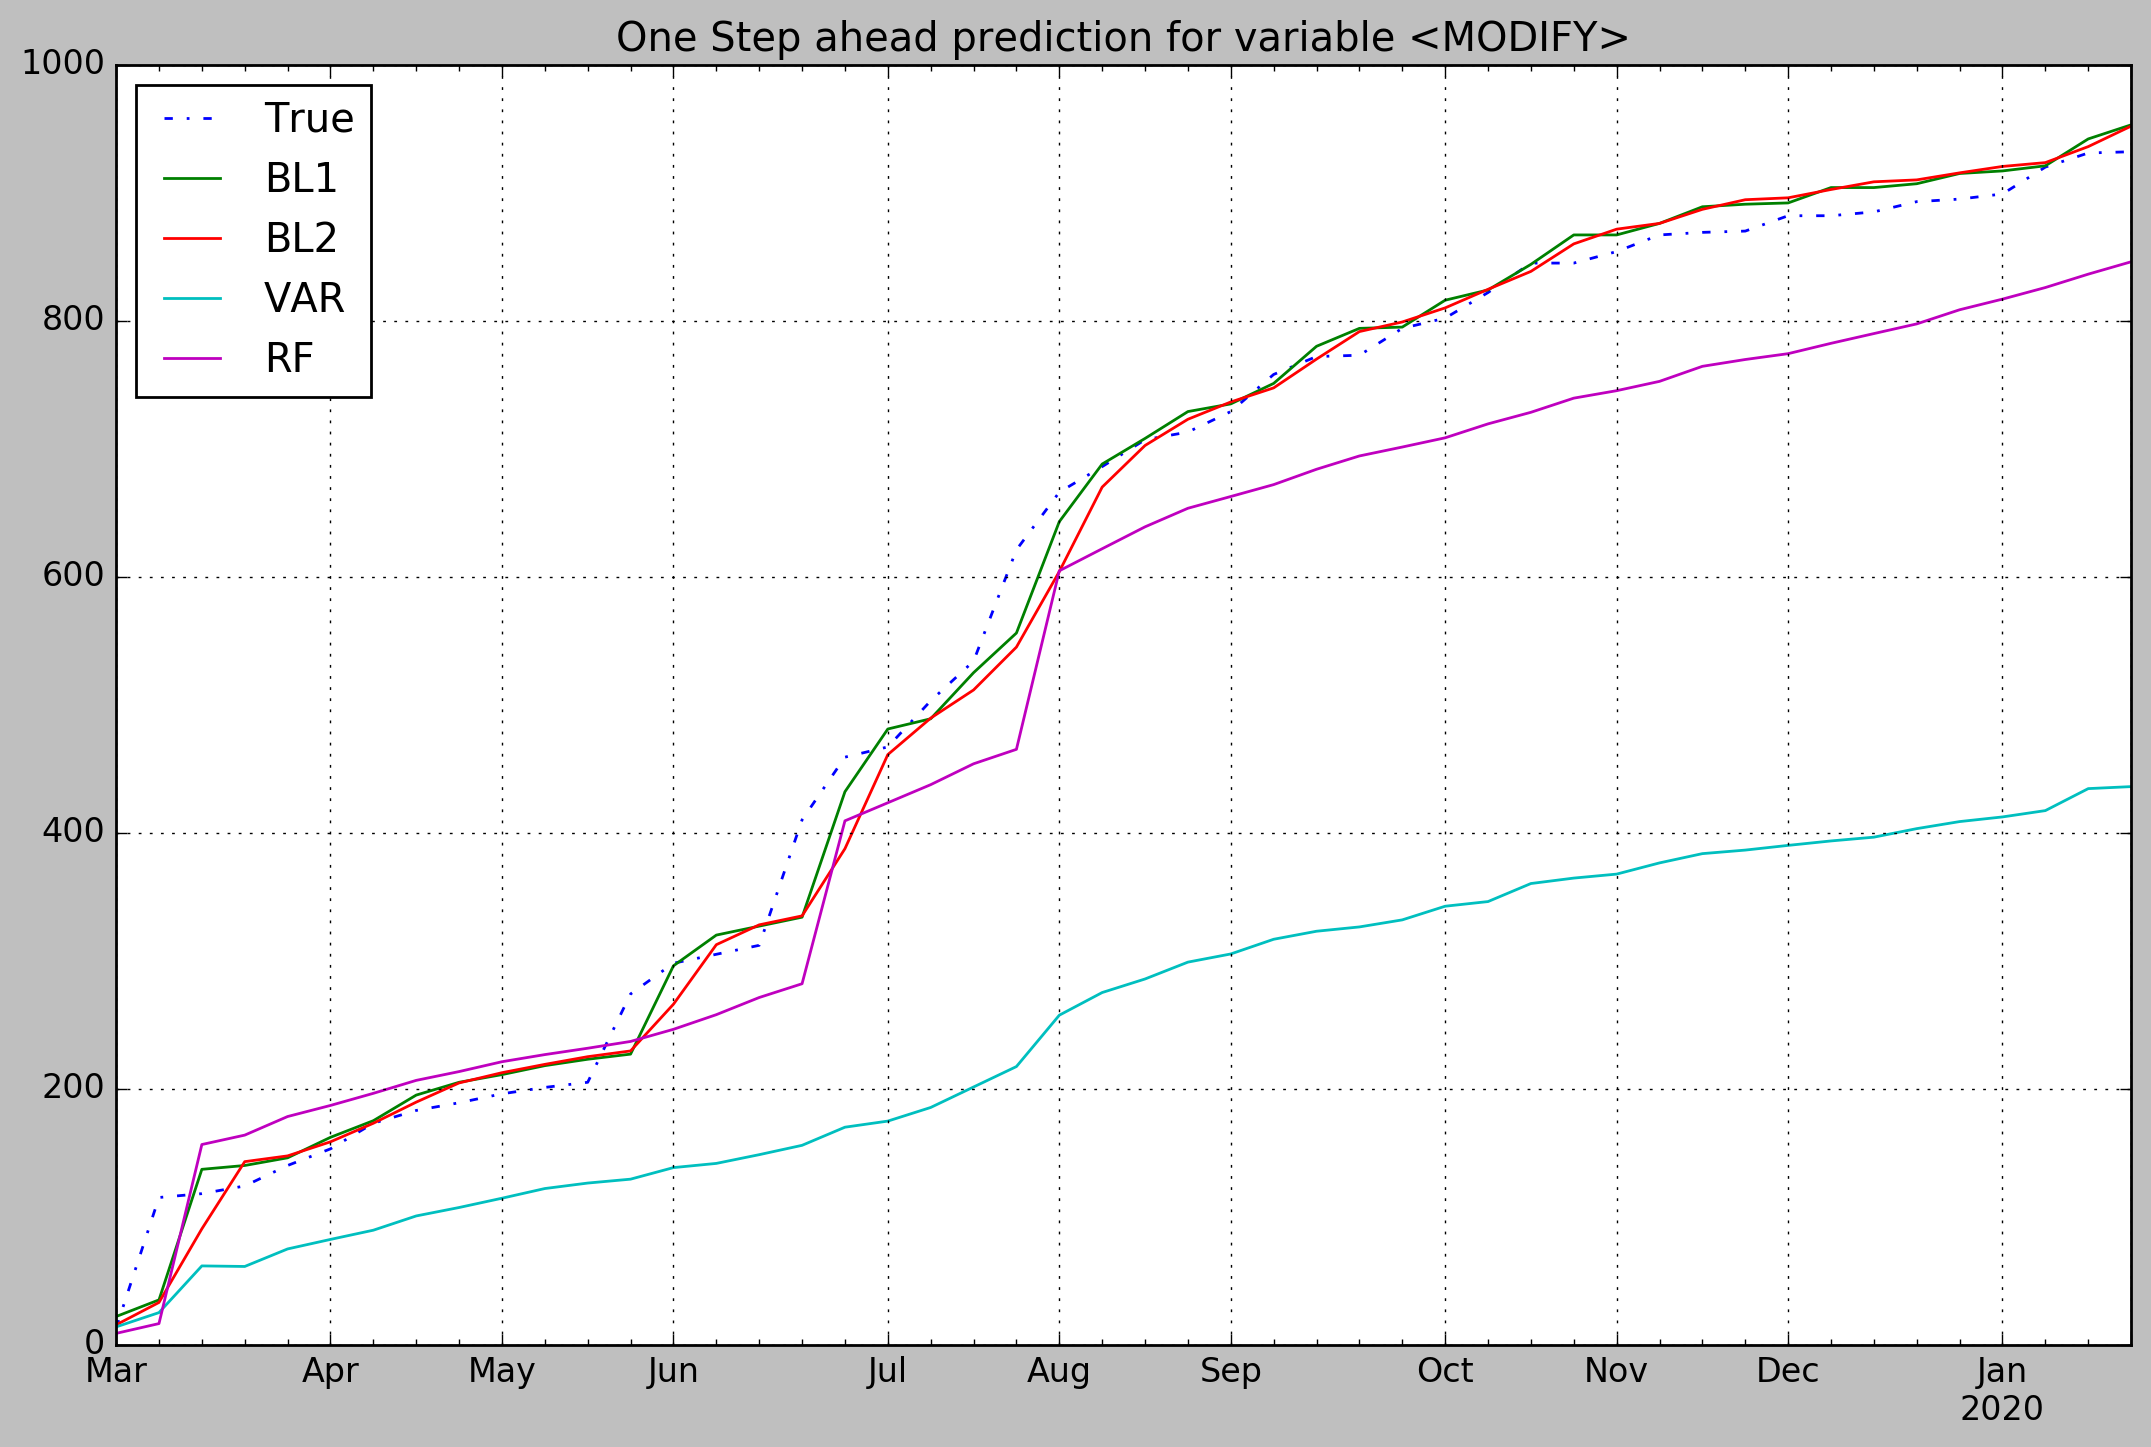

In [16]:
compare_predictions("modify", "1w", "Mexico City").cumsum().plot(grid=True, style=["-.", "-"]);plt.title("One Step ahead prediction for variable <MODIFY>")

In [188]:
res = model_predictions("1w", "Heidelberg")